In [1]:
import numpy as np
import os
from pImpactR import MLI as mli
from pImpactR import opt
from pImpactR.util import Me
from pImpactR.plot import density
from copy import deepcopy as copy
import time
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
nturn = 256
npt = 2048*2
emit = 2.0e-6
Espread = 2.0e-3

# Read MLI input for settings

In [3]:
elems,latticeList,labor = mli.readInputfile('mli.in.t3_iota_8_4_t0p4')
# elems[2].driftexact=1
elems,latticeList=mli.sext2thin(elems,latticeList,brho=0.50204778184582999)

setarclen is not recognized. skipping...
autoconcat is not recognized. skipping...
autoapply is not recognized. skipping...
reftraj is not recognized. skipping...
fit is not recognized. skipping...
bip is not recognized. skipping...
tip is not recognized. skipping...


In [4]:
elemList = []
for item in elems:
    if not item.elem in ['tasm','aim','vary','anaprint','monitor']:
        elemList.append(item)

In [5]:
energy=elems[0].energy*1.0e9
gam0 = energy/Me
bet0 = np.sqrt(1.0-1.0/gam0**2)

In [6]:
NL_nu = 0.3
NL_L  = 1.8
NL_c  = 0.01
NL_t  = 0.4
alfx = np.tan(np.pi*NL_nu)
betx = NL_L/np.sin(2.0*np.pi*NL_nu)
k = 2*alfx/betx


f3 = k/(2*bet0)
f4 = k/(2*bet0*gam0)**2
print(bet0,k,f3,f4)

0.99999423665409 1.4544633270832747 0.727235854853427 4.191323867725334e-06


In [7]:
def MLI2norm(data_in,sign=1):
    data=data_in.copy()
    data[:,5] = np.sqrt(1.0-2.0*data[:,5]/bet0+data[:,5]**2)-1.0
    data[:,1] = data[:,0]*alfx/np.sqrt(betx) + data[:,1]/(1+data[:,5])*np.sqrt(betx)
    data[:,3] = data[:,2]*alfx/np.sqrt(betx) + data[:,3]/(1+data[:,5])*np.sqrt(betx)
    data[:,0] = data[:,0]/(np.sqrt(betx))
    data[:,2] = data[:,2]/(np.sqrt(betx))
    return data
    
def norm2MLI(data_in,sign=1):
    data=data_in.copy()
    data[:,1] = (-data[:,0]*alfx*sign + data[:,1])/np.sqrt(betx)*(1+data[:,5])
    data[:,3] = (-data[:,2]*alfx*sign + data[:,3])/np.sqrt(betx)*(1+data[:,5])
    data[:,0] = data[:,0]*np.sqrt(betx)
    data[:,2] = data[:,2]*np.sqrt(betx)
    data[:,5] = -np.sqrt((1.0+data[:,5])**2+1.0/(bet0*gam0)**2)+1.0/bet0
    return data

In [8]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0, sd=1, low=0, upp=3,n=1):
    f = truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)
    return f.rvs(n)

In [9]:
bg = gam0*bet0
sx = np.sqrt(betx*emit)
spx = np.sqrt((1+alfx*alfx)/betx*emit)
sy = np.sqrt(betx*emit)
spy = np.sqrt((1+alfx*alfx)/betx*emit)
se = 2.0e-3*bet0
print(sx,spx,se)

0.0019455754951319061 0.001748892932667961 0.0019999884733081803


In [10]:
x=get_truncated_normal(sd=1,low=-3,upp=3,n=npt*5)
pData=np.zeros([npt,6])
pData[:,[0,1,2,3,5]]=x.reshape([npt,5])
pData[:,:4] = pData[:,:4]*np.sqrt(emit)
pData[:,5] = pData[:,5]*Espread
# np.save('pDataNorm.std=0.1',pData)
# pData = np.load('pDataNorm.std=0.1.npy')

pDataIn = norm2MLI(pData,sign=1)
np.savetxt('rays.in',pDataIn)

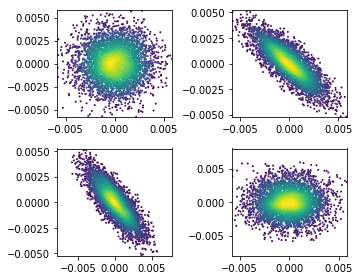

In [11]:
plt.figure(figsize=(5,4))
plt.subplot(2,2,1)
density(pDataIn[:,0],pDataIn[:,2])
plt.xlim(-3*sx,3*sx)
plt.ylim(-3*sy,3*sy)
plt.subplot(2,2,2)
density(pDataIn[:,0],pDataIn[:,1])
plt.xlim(-3*sx,3*sx)
plt.ylim(-3*spx,3*spx)
plt.subplot(2,2,3)
density(pDataIn[:,2],pDataIn[:,3])
plt.xlim(-4*sx,4*sx)
plt.ylim(-3*spx,3*spx)
plt.subplot(2,2,4)
density(pDataIn[:,0],pDataIn[:,5])
plt.ylim(-4*se,4*se)
plt.tight_layout()

# Cmds

In [12]:
raysin  =mli.getElem.raytrace(file1='rays.in',type='readonly')
dump    =mli.getElem.particledump(file='rays.out',precision=15)
track   =mli.getElem.autotrack(type='symplectic',order=5)
fin     =mli.getElem.fin

elemList = elemList + [raysin, dump, track, fin]

In [13]:
# labor = mli.buildLabor(['iotaline','mapout'])
# mli.writeInputfile(elemList,latticeList,labor)
# mli.run()

# Lattice

In [14]:
nlinsert=mli.getElem.nlinsert()

iotaline = latticeList[0]
arc = copy(iotaline)
arc.name = 'arc'
iotaline.list.insert(0,nlinsert.name)
iotaline.list.append(dump.name)

elemList = elemList + [nlinsert]

In [15]:
indexThin = []
for i,item in enumerate(elemList):
    if 'thlm' == item.elem:
        indexThin.append(i)
nThin = len(indexThin)
print(nThin)

18


# Labor

In [16]:
labor = mli.buildLabor(['iotaline','mapout','clear',raysin.name,track.name,str(nturn)+'*'+iotaline.name,'fin'])
maplabor = mli.buildLabor(['arc','mapout'])

#  Run

In [17]:
def getTBT(npt,nturn,fname='rays.out'):
    TBT = np.loadtxt(fname)
    TBT = TBT[:npt*nturn,:6]
    out = np.zeros([npt,nturn,6])
    for i in range(nturn):
        out[:,i,:] = TBT[i*npt:(i+1)*npt,:]
        out[:,i,:] = MLI2norm(out[:,i,:])
    return out

In [18]:
def updateStrength(arg):
    for i,j in enumerate(indexThin):
        elemList[j]['k2l']=arg[i]

In [19]:
updateStrength([0.0]*nThin)
mli.writeInputfile(elemList,latticeList,labor)
mli.run(4)
!mv mli.log mli.0.log
TBT0 = getTBT(npt,nturn)
print(TBT0.shape)

(4096, 256, 6)


In [20]:
import pickle
# with open('result.thin.sext.oct','rb') as fp:
# with open('result.thin.3sig.sext','rb') as fp:
with open('result.Inv.thin.1sig.sext','rb') as fp:
    result=pickle.load(fp)

In [21]:
# result.x

In [22]:
# TBT = np.loadtxt('rays.out')

In [23]:
# updateStrength(result.x)
arg = result.population[0,:]
arg = arg*200-100
updateStrength(arg)
mli.writeInputfile(elemList,latticeList,labor)
mli.run(4)
!mv mli.log mli.1.log
TBT1 = getTBT(npt,nturn)
print(TBT1.shape)

(4096, 256, 6)


In [24]:
mli.writeInputfile(elemList,[arc],maplabor)
mli.run()
M,G=mli.readTransferMap()

In [25]:
readmap = mli.getElem.tmi(name='readmap')
readmap.map2file(M,G)
savemap = mli.getElem.stm(name='savemap')
arcM    = mli.getElem.gtm(name='arcM')
elemList = elemList + [readmap,savemap,arcM]
iotaline.list=[iotaline.list[0],'arcM',iotaline.list[-1]]
labor.list = ['readmap','savemap','arcM','clear'] + labor.list[-4:]
mli.writeInputfile(elemList,latticeList,labor)
mli.run(4)
!mv mli.log mli.2.log
TBT2 = getTBT(npt,nturn)
print(TBT2.shape)

(4096, 256, 6)


# Check invariants

In [26]:
def getInv(xn,pxn,yn,pyn,delta,tau=NL_t):
    z = xn + 1j*yn
    U = np.real(z/np.sqrt(1-z**2)*np.arcsin(z))
    W = np.real(2*xn/np.sqrt(1-z**2)*np.arcsin(z))
    Hn = 0.5*(xn**2+pxn**2+yn**2+pyn**2)   +tau*U/(1.0+delta)
    In = (xn*pyn -yn*pxn)**2 +xn**2+pxn**2 +tau*W/(1.0+delta)
    return Hn,In

def getInvTBT(TBT):
    npt,nturn,dummy = TBT.shape
    InvTBT = np.zeros([npt,nturn,2])
    for iturn in range(nturn):
        data = TBT[:,iturn,:]
        for ipt in range(npt):
            xn    = data[ipt,0]
            pxn   = data[ipt,1]
            yn    = data[ipt,2]
            pyn   = data[ipt,3]
            delta = data[ipt,5]
            InvTBT[ipt,iturn,:] = getInv(xn,pxn,yn,pyn,delta)
    return InvTBT

In [27]:
Inv0 = getInvTBT(TBT0)
Inv1 = getInvTBT(TBT1)
Inv2 = getInvTBT(TBT2)

/home/kilean/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: overflow encountered in double_scalars
  


In [28]:
Inv0.shape

(4096, 256, 2)

In [29]:
def getRegular(Inv):
    return np.logical_not(np.isnan(np.std(Inv[:,:,0],1)/Inv[:,0,0]+
                                   np.std(Inv[:,:,1],1)/Inv[:,0,1]))

In [30]:
print(np.sum(getRegular(Inv0)),np.sum(getRegular(Inv1)),np.sum(getRegular(Inv2)))

4096 4031 4034


In [31]:
index = getRegular(Inv0)*getRegular(Inv1)*getRegular(Inv2)

In [32]:
index0 = getRegular(Inv0)
index1 = getRegular(Inv1)
index2 = getRegular(Inv2)
print(np.sum(index0),np.sum(index1),np.sum(index2))

4096 4031 4034


In [33]:
Inv0=Inv0[index,:,:]
Inv1=Inv1[index,:,:]
Inv2=Inv2[index,:,:]

In [34]:
npt=np.sum(index)
print(npt)

4013


### Absolute

In [35]:
print('--max invarinats--')
print(np.max(Inv0[:,:,0]),np.max(Inv0[:,:,1]))
print(np.max(Inv1[:,:,0]),np.max(Inv1[:,:,1]))
print(np.max(Inv2[:,:,0]),np.max(Inv2[:,:,1]))

--max invarinats--
3.826962084096603e-05 7.069872384515564e-05
0.6762077467859265 1.3524155865650047
9.298894000420185e-05 0.00018320204335092093


In [36]:
amp0 = np.zeros([npt,2])
amp1 = np.zeros([npt,2])
amp2 = np.zeros([npt,2])
for i in range(npt):
    amp0[i,0] = np.std(Inv0[i,:,0])
    amp0[i,1] = np.std(Inv0[i,:,1])
    amp1[i,0] = np.std(Inv1[i,:,0])
    amp1[i,1] = np.std(Inv1[i,:,1])
    amp2[i,0] = np.std(Inv2[i,:,0])
    amp2[i,1] = np.std(Inv2[i,:,1])
print('--mean of amplitudes--')
print(amp0[:,0].mean(),amp0[:,1].mean())
print(amp1[:,0].mean(),amp1[:,1].mean())
print(amp2[:,0].mean(),amp2[:,1].mean())

--mean of amplitudes--
2.3647700104439213e-07 3.5308933381652966e-07
1.0760522277950482e-05 2.1446536170221154e-05
2.44114171757113e-07 4.1579676166761444e-07


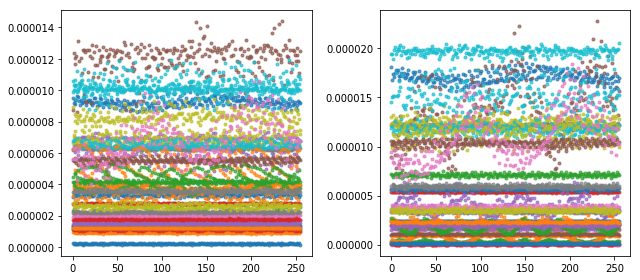

In [37]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(32):
    plt.plot(Inv0[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(32):
    plt.plot(Inv0[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

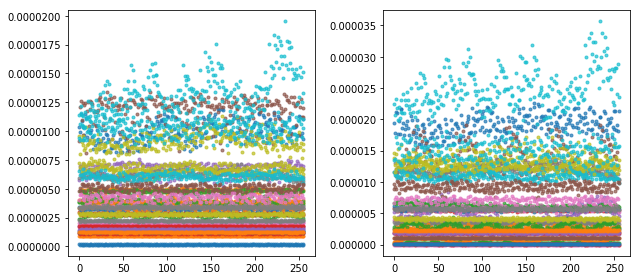

In [38]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(32):
    plt.plot(Inv1[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(32):
    plt.plot(Inv1[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

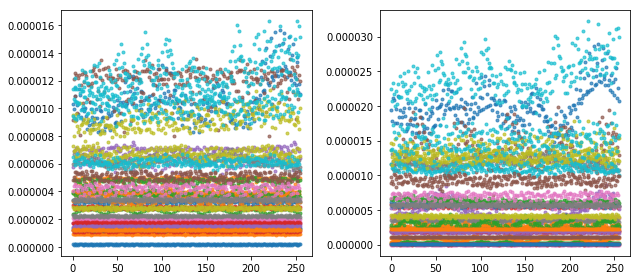

In [39]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(32):
    plt.plot(Inv2[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(32):
    plt.plot(Inv2[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

### Relative

In [40]:
for i in range(npt):
    Inv0[i,:,0] = Inv0[i,:,0]/Inv0[i,0,0].mean()-1.0
    Inv0[i,:,1] = Inv0[i,:,1]/Inv0[i,0,1].mean()-1.0
    Inv1[i,:,0] = Inv1[i,:,0]/Inv1[i,0,0].mean()-1.0
    Inv1[i,:,1] = Inv1[i,:,1]/Inv1[i,0,1].mean()-1.0
    Inv2[i,:,0] = Inv2[i,:,0]/Inv2[i,0,0].mean()-1.0
    Inv2[i,:,1] = Inv2[i,:,1]/Inv2[i,0,1].mean()-1.0

In [41]:
print('--max invarinats--')
print(np.max(Inv0[:,:,0]),np.max(Inv0[:,:,1]))
print(np.max(Inv1[:,:,0]),np.max(Inv1[:,:,1]))
print(np.max(Inv2[:,:,0]),np.max(Inv2[:,:,1]))

--max invarinats--
3.2499111269563805 372.51175162526494
59719.07052966424 61652.196778544494
8.298489278245448 1362.7153043640694


In [42]:
print('--std--')
print(np.std(Inv0[:,:,0]),np.std(Inv0[:,:,1]))
print(np.std(Inv1[:,:,0]),np.std(Inv1[:,:,1]))
print(np.std(Inv2[:,:,0]),np.std(Inv2[:,:,1]))

--std--
0.13424984097532616 2.7874827965109126
58.91948928070149 61.652637709034394
0.10737665858602834 9.860285517216827


In [43]:
amp0 = np.zeros([npt,2])
amp1 = np.zeros([npt,2])
amp2 = np.zeros([npt,2])
for i in range(npt):
    amp0[i,0] = np.std(Inv0[i,:,0])
    amp0[i,1] = np.std(Inv0[i,:,1])
    amp1[i,0] = np.std(Inv1[i,:,0])
    amp1[i,1] = np.std(Inv1[i,:,1])
    amp2[i,0] = np.std(Inv2[i,:,0])
    amp2[i,1] = np.std(Inv2[i,:,1])
print('--mean of amplitudes--')
print(amp0[:,0].mean(),amp0[:,1].mean())
print(amp1[:,0].mean(),amp1[:,1].mean())
print(amp2[:,0].mean(),amp2[:,1].mean())

--mean of amplitudes--
0.06563193591360791 0.1380994750865827
0.9847506911603703 1.1585353546856298
0.05587998828943278 0.19753650333022918


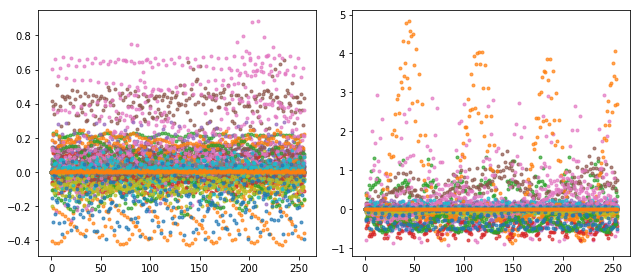

In [44]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(32):
    plt.plot(Inv0[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(32):
    plt.plot(Inv0[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

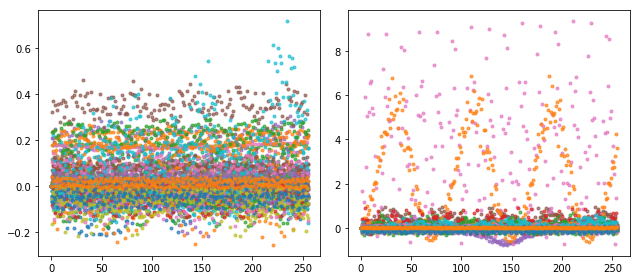

In [45]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(32):
    plt.plot(Inv1[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(32):
    plt.plot(Inv1[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

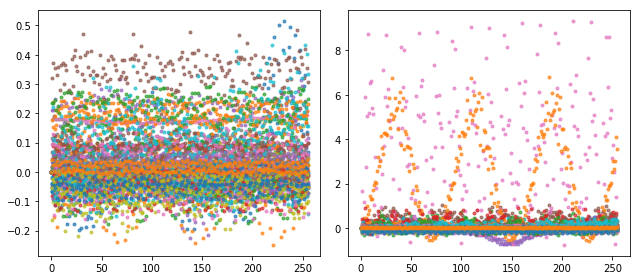

In [46]:
fig=plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
for i in range(32):
    plt.plot(Inv2[i,:,0],marker='.',ls='',alpha=0.7)
plt.subplot(1,2,2)
for i in range(32):
    plt.plot(Inv2[i,:,1],marker='.',ls='',alpha=0.7)
plt.tight_layout()

In [47]:
index1 = np.argsort(np.std(Inv2[:,:,0],axis=0))[::-1]

In [48]:
def getInv(xn,pxn,yn,pyn,delta,tau=NL_t):
    z = xn + 1j*yn
    U = np.real(z/np.sqrt(1-z**2)*np.arcsin(z))
    W = np.real(2*xn/np.sqrt(1-z**2)*np.arcsin(z))
    Hn = 0.5*(xn**2+pxn**2+yn**2+pyn**2)   +tau*U/(1.0+delta)
    In = (xn*pyn -yn*pxn)**2 +xn**2+pxn**2 +tau*W/(1.0+delta)
    return Hn,In

test2 = np.zeros([npt,2])
for ipt in range(npt):
    xn    = pData[ipt,0]
    pxn   = pData[ipt,1]
    yn    = pData[ipt,2]
    pyn   = pData[ipt,3]
    delta = pData[ipt,5]
    test2[ipt,:] = getInv(xn,pxn,yn,pyn,delta)

In [49]:
test2 = (test2[:,1] - 2*test2[:,0])**2/test2[:,0]
index2 = np.argsort(test2)

In [50]:
np.sum(np.in1d(index1[:int(0.1*npt)],index2[:int(0.1*npt)]))/int(0.1*npt)

0.07481296758104738